In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%reset -f
%config Completer.use_jedi = False
from platform import python_version
print(python_version())
!nvidia-smi

3.6.8
Sat Sep 25 14:20:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GRID V100D-32Q      On   | 00000000:02:00.0 Off |                  N/A |
| N/A   N/A    P0    N/A /  N/A |   2192MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import os
import math
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from skimage.transform import rescale
from skimage.color import rgb2gray, label2rgb
import statistics
from tqdm import tqdm
import torchvision
from torchmetrics.functional import iou, accuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def memory_usage(t):
    return t.element_size() * t.nelement()
    
class StopExecution(Exception):
    def _render_traceback_(self):
        pass
    
def stop():
    raise StopExecution

cuda:0


In [3]:
H = 64
W = 128

# used = [7, 26, 11]

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files):
        self.files = files

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        x,y = torch.load(self.files[idx])
        x = torchvision.transforms.Resize(H)(x)
        y = torchvision.transforms.Resize(H, torchvision.transforms.InterpolationMode.NEAREST)(torch.unsqueeze(y,0))
        y = torch.squeeze(y)
        a = torch.zeros(y.shape)
        a[y==7] = 1
        a = torch.unsqueeze(a,0)
        b = torch.zeros(y.shape)
        b[y==26] = 1
        b = torch.unsqueeze(b,0)
        c = torch.zeros(y.shape)
        c[y==11] = 1
        c = torch.unsqueeze(c,0)
        y = torch.cat((a,b,c), dim=0)
        return x, y
    
files = []
for i in range(17045):
    files.append("/data/s2967057/citytensors/newcoarse/{}.pt".format(i+1))

    
cityscapes = CustomDataset(files)
# Change the split depending on how much time and gpu power you have. Full 0.9 0.1 split can take quite long
temp, _ = torch.utils.data.random_split(cityscapes, [int(0.75 * len(cityscapes)) + 1, int(0.25 * len(cityscapes))])
train, test = torch.utils.data.random_split(temp, [int(0.8 * len(temp)) + 1, int(0.2 * len(temp))])


params = {'batch_size': 15,
          'shuffle': True,
          'num_workers': 4,
          'pin_memory': False}

trainloader = torch.utils.data.DataLoader(train, **params)

testloader = torch.utils.data.DataLoader(test, **params)

In [12]:
'''
These are the boolean conceptor operations. Adopted directly from Jaeger's 2017 report. 
NB: these operations work only on conceptors with singular values between 0 and 1, 
which is completely fine for this project. If you want to use them for other matrices use the 
operations defined in terms of the svd, also explained in Jaeger 2017, adopted by Xu He found here:
https://github.com/he-xu/CAB/blob/master/logic.py
'''

def NOT(C):
    dim = C.shape[0]
    not_C = np.eye(dim) - C
    return not_C

def AND(C, B, tol = 1e-14):
    dim = C.shape[0]
    C_and_B = np.linalg.inv(np.linalg.inv(C) + np.linalg.inv(B) - np.eye(dim))
    return C_and_B

def OR(R, Q):
    R_or_Q = NOT(AND(NOT(R), NOT(Q)))
    return R_or_Q
    
def plot_spectrum(S):
    x = np.linspace(0,S.shape[0],S.shape[0])
    plt.autoscale(True)
    plt.plot(x, S)
    plt.show()

def conceptor(X, alpha=4):
    R = (X.T).dot(X) / X.shape[0]
    U, S, _ = np.linalg.svd(R)
    S_C = (np.diag(S).dot(np.linalg.inv(np.diag(S) + alpha ** (-2) * np.eye(X.shape[1]))))
    plot_spectrum(np.diag(S_C))
    C = U.dot(S_C).dot(U.T)
    return C, S, np.diag(S_C)

In [13]:
# Parameters for kernel size, padding and numer of filters (channels)
k = 5
p = 2
cha = 16

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # All operations are conv operations
        self.w1 = nn.Parameter(torch.empty((k*k*3, 1*cha)))
        self.w2 = nn.Parameter(torch.empty((k*k*1*cha, 2*cha)))
        self.w3 = nn.Parameter(torch.empty((k*k*2*cha, 4*cha)))
        self.w4 = nn.Parameter(torch.empty((k*k*4*cha, 8*cha)))
        self.w5 = nn.Parameter(torch.empty((k*k*8*cha, 4*cha)))
        self.w6 = nn.Parameter(torch.empty((k*k*4*cha, 2*cha)))
        self.w7 = nn.Parameter(torch.empty((k*k*2*cha, 1*cha)))
        self.w8 = nn.Parameter(torch.empty((k*k*1*cha, 1)))
            
        self.w1_old = nn.Parameter(torch.zeros((k*k*3, 1*cha), requires_grad=False))
        self.w2_old = nn.Parameter(torch.zeros((k*k*1*cha, 2*cha), requires_grad=False))
        self.w3_old = nn.Parameter(torch.zeros((k*k*2*cha, 4*cha), requires_grad=False))
        self.w4_old = nn.Parameter(torch.zeros((k*k*4*cha, 8*cha), requires_grad=False))
        self.w5_old = nn.Parameter(torch.zeros((k*k*8*cha, 4*cha), requires_grad=False))
        self.w6_old = nn.Parameter(torch.zeros((k*k*4*cha, 2*cha), requires_grad=False))
        self.w7_old = nn.Parameter(torch.zeros((k*k*2*cha, 1*cha), requires_grad=False))
        self.w8_old = nn.Parameter(torch.zeros((k*k*1*cha, 1), requires_grad=False))
        
        self.act = nn.ReLU()
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.weights = [self.w1, self.w2, self.w3, self.w4, self.w5, self.w6, self.w7, self.w8]
        
        self.head = []
    
    def forward(self, x):
        self.x0 = F.unfold(x, k, 1, p, 1).transpose(1,2)
        
        self.x1 = F.relu(self.x0.matmul(self.w1 + self.w1_old)).transpose(1,2)
        self.x1 = self.x1.view(self.x1.shape[0], cha, H, W)
        self.x1 = self.pool(self.x1)
        self.x1 = F.unfold(self.x1, k, 1, p, 1).transpose(1,2)
        
        self.x2 = F.relu(self.x1.matmul(self.w2 + self.w2_old)).transpose(1,2)
        self.x2 = self.x2.view(self.x2.shape[0], 2*cha, H//2, W//2)
        self.x2 = self.pool(self.x2)
        self.x2 = F.unfold(self.x2, k, 1, p, 1).transpose(1,2)

        self.x3 = F.relu(self.x2.matmul(self.w3 + self.w3_old)).transpose(1,2)
        self.x3 = self.x3.view(self.x3.shape[0], 4*cha, H//4, W//4)
        self.x3 = self.pool(self.x3)
        self.x3 = F.unfold(self.x3, k, 1, p, 1).transpose(1,2)
        
        self.x4 = F.relu(self.x3.matmul(self.w4 + self.w4_old)).transpose(1,2)
        self.x4 = self.x4.view(self.x4.shape[0], 8*cha, H//8, W//8)
        self.x4 = self.upsample(self.x4)
        self.x4 = F.unfold(self.x4, k, 1, p, 1).transpose(1,2)
        
        self.x5 = F.relu(self.x4.matmul(self.w5 + self.w5_old)).transpose(1,2)
        self.x5 = self.x5.view(self.x5.shape[0], 4*cha, H//4, W//4)
        self.x5 = self.upsample(self.x5)
        self.x5 = F.unfold(self.x5, k, 1, p, 1).transpose(1,2)
        
        self.x6 = F.relu(self.x5.matmul(self.w6 + self.w6_old)).transpose(1,2)
        self.x6 = self.x6.view(self.x6.shape[0], 2*cha, H//2, W//2)
        self.x6 = self.upsample(self.x6)
        self.x6 = F.unfold(self.x6, k, 1, p, 1).transpose(1,2)
        
        self.x7 = F.relu(self.x6.matmul(self.w7 + self.w7_old)).transpose(1,2)
        self.x7 = self.x7.view(self.x7.shape[0], 1*cha, H, W)
        self.x7 = F.unfold(self.x7, k, 1, p, 1).transpose(1,2)
        
        self.x8 = self.x7.matmul(self.w8 + self.w8_old).transpose(1,2)
        self.x8 = self.x8.view(self.x8.shape[0], 1, H, W)
        
        return torch.squeeze(self.x8)
    
    def initialise(self):
        nn.init.xavier_uniform_(self.w1, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.w2, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.w3, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.w4, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.w5, gain=nn.init.calculate_gain('relu')) 
        nn.init.xavier_uniform_(self.w6, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.w7, gain=nn.init.calculate_gain('relu')) 
        nn.init.xavier_uniform_(self.w8, gain=nn.init.calculate_gain('sigmoid'))       

    
model = Net().to(device)
model.initialise()

ce_loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.weights)

def l2_norm(x):
    return torch.sum(torch.pow(x, 2)) / 2

def l2_loss(params):
    loss = 0
    for p in params:
        loss += l2_norm(p)
    return loss

def c_loss(m, c1, c2, c3, c4, c5, c6, c7):
#     noise1 = torch.normal(0,1,model.x0.shape).to(device)
    noise1 = torch.cuda.FloatTensor(model.x0.shape).normal_()
    a_old1 = F.relu(noise1.matmul(m.w1_old)).transpose(1,2)  
    a_new1 = F.relu(noise1.matmul(m.w1 + m.w1_old)).transpose(1,2)
#     a_old1 = F.max_pool2d(a_old1.view(a_old1.shape[0], 16, 28, 28), kernel_size=2)
#     a_new1 = F.max_pool2d(a_new1.view(a_new1.shape[0], 16, 28, 28), kernel_size=2)
    diff1 = (a_new1 - a_old1).view(a_new1.shape[0],1*cha,H,W)
    diff1 = F.unfold(diff1, k, 1, p, 1).transpose(1,2)
    diff1 = diff1.matmul(c1)
    reg1 = l2_norm(diff1)
    
#     noise2 = torch.normal(0,1,model.x1.shape).to(device)
    noise2 = torch.cuda.FloatTensor(model.x1.shape).normal_()
    a_old2 = F.relu(noise2.matmul(m.w2_old)).transpose(1,2)  
    a_new2 = F.relu(noise2.matmul(m.w2 + m.w2_old)).transpose(1,2)
#     a_old1 = F.max_pool2d(a_old1.view(a_old1.shape[0], 16, 28, 28), kernel_size=2)
#     a_new1 = F.max_pool2d(a_new1.view(a_new1.shape[0], 16, 28, 28), kernel_size=2)
    diff2 = (a_new2 - a_old2).view(a_new2.shape[0],2*cha,H//2,W//2)
    diff2 = F.unfold(diff2, k, 1, p, 1).transpose(1,2)
    diff2 = diff2.matmul(c2)
    reg2 = l2_norm(diff2)
    
#     noise3 = torch.normal(0,1,model.x2.shape).to(device)
    noise3 = torch.cuda.FloatTensor(model.x2.shape).normal_()
    a_old3 = F.relu(noise3.matmul(m.w3_old)).transpose(1,2)  
    a_new3 = F.relu(noise3.matmul(m.w3 + m.w3_old)).transpose(1,2)
#     a_old1 = F.max_pool2d(a_old1.view(a_old1.shape[0], 16, 28, 28), kernel_size=2)
#     a_new1 = F.max_pool2d(a_new1.view(a_new1.shape[0], 16, 28, 28), kernel_size=2)
    diff3 = (a_new3 - a_old3).view(a_new3.shape[0],4*cha,H//4,W//4)
    diff3 = F.unfold(diff3, k, 1, p, 1).transpose(1,2)
    diff3 = diff3.matmul(c3)
    reg3 = l2_norm(diff3)
    
#     noise4 = torch.normal(0,1,model.x3.shape).to(device)
    noise4 = torch.cuda.FloatTensor(model.x3.shape).normal_()
    a_old4 = F.relu(noise4.matmul(m.w4_old)).transpose(1,2)  
    a_new4 = F.relu(noise4.matmul(m.w4 + m.w4_old)).transpose(1,2)
#     a_old1 = F.max_pool2d(a_old1.view(a_old1.shape[0], 16, 28, 28), kernel_size=2)
#     a_new1 = F.max_pool2d(a_new1.view(a_new1.shape[0], 16, 28, 28), kernel_size=2)
    diff4 = (a_new4 - a_old4).view(a_new4.shape[0],8*cha,H//8,W//8)
    diff4 = F.unfold(diff4, k, 1, p, 1).transpose(1,2)
    diff4 = diff4.matmul(c4)
    reg4 = l2_norm(diff4)
    
#     noise5 = torch.normal(0,1,model.x4.shape).to(device)
    noise5 = torch.cuda.FloatTensor(model.x4.shape).normal_()
    a_old5 = F.relu(noise5.matmul(m.w5_old)).transpose(1,2)  
    a_new5 = F.relu(noise5.matmul(m.w5 + m.w5_old)).transpose(1,2)
#     a_old1 = F.max_pool2d(a_old1.view(a_old1.shape[0], 16, 28, 28), kernel_size=2)
#     a_new1 = F.max_pool2d(a_new1.view(a_new1.shape[0], 16, 28, 28), kernel_size=2)
    diff5 = (a_new5 - a_old5).view(a_new5.shape[0],4*cha,H//4,W//4)
    diff5 = F.unfold(diff5, k, 1, p, 1).transpose(1,2)
    diff5 = diff5.matmul(c5)
    reg5 = l2_norm(diff5)
    
#     noise6 = torch.normal(0,1,model.x5.shape).to(device)
    noise6 = torch.cuda.FloatTensor(model.x5.shape).normal_()
    a_old6 = F.relu(noise6.matmul(m.w6_old)).transpose(1,2)  
    a_new6 = F.relu(noise6.matmul(m.w6 + m.w6_old)).transpose(1,2)
#     a_old1 = F.max_pool2d(a_old1.view(a_old1.shape[0], 16, 28, 28), kernel_size=2)
#     a_new1 = F.max_pool2d(a_new1.view(a_new1.shape[0], 16, 28, 28), kernel_size=2)
    diff6 = (a_new6 - a_old6).view(a_new6.shape[0],2*cha,H//2,W//2)
    diff6 = F.unfold(diff6, k, 1, p, 1).transpose(1,2)
    diff6 = diff6.matmul(c6)
    reg6 = l2_norm(diff6)
    
#     noise7 = torch.normal(0,1,model.x6.shape).to(device)
    noise7 = torch.cuda.FloatTensor(model.x6.shape).normal_()
    a_old7 = F.relu(noise7.matmul(m.w7_old)).transpose(1,2)  
    a_new7 = F.relu(noise7.matmul(m.w7 + m.w7_old)).transpose(1,2)
#     a_old1 = F.max_pool2d(a_old1.view(a_old1.shape[0], 16, 28, 28), kernel_size=2)
#     a_new1 = F.max_pool2d(a_new1.view(a_new1.shape[0], 16, 28, 28), kernel_size=2)
    diff7 = (a_new7 - a_old7).view(a_new7.shape[0],1*cha,H,W)
    diff7 = F.unfold(diff7, k, 1, p, 1).transpose(1,2)
    diff7 = diff7.matmul(c7)
    reg7 = l2_norm(diff7)
    
    loss = reg1 + reg2 + reg3 + reg4 + reg5 + reg6 + reg7
    return loss

In [16]:
num_tasks = 2

def overall_pixel_accuracy():
    loss = []
    model.w8_old = nn.Parameter(torch.zeros(model.w8_old.shape, device=device))
    for i in range(num_tasks):
        model.w8 = nn.Parameter(model.head[i])
        for x,y in testloader:
            x,y = x.to(device), y.to(device)
            out = model(x.float())
            out[out>0.5] = 1
            out[out!=1] = 0
            y = y[:,i,:,:]
            loss.append(accuracy(out, y.int()).item())
    return statistics.mean(loss)

def task_pixel_accuracy(task):
    loss = []
    for x,y in testloader:
        x,y = x.to(device), y.to(device)
        out = model(x.float())
        out[out>0.5] = 1
        out[out!=1] = 0
        out = out[:,task,:,:]
        y = y[:,task,:,:]
        loss.append(accuracy(out, y.int()).item())
    return statistics.mean(loss)

# IoU mean over all classes
def overall_iou():
    loss = []
    model.w8_old = nn.Parameter(torch.zeros(model.w8_old.shape, device=device))
    for i in range(num_tasks):
        model.w8 = nn.Parameter(model.head[i])
        for x,y in testloader:
            x,y = x.to(device), y.to(device)
            out = model(x.float())
            out[out>0.5] = 1
            out[out!=1] = 0
            y = y[:,i,:,:]
            loss.append(iou(out, y.int()).item())
    return statistics.mean(loss)
    
# IoU per class, pass task num
def task_iou(task):
    loss = []
    for x,y in testloader:
        x,y = x.to(device), y.to(device)
        out = model(x.float())
        out[out>0.5] = 1
        out[out!=1] = 0
        out = out[:,task,:,:]
        y = y[:,task,:,:]
        loss.append(iou(out, y.int()).item())
    return statistics.mean(loss)


0.540365848799198
0.8404209796796765


Task 1


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.20345635345080032


 20%|██        | 1/5 [01:09<04:36, 69.05s/it]

Test/validation loss: 0.150288807761948
Train loss: 0.14335749300519043


 40%|████      | 2/5 [01:39<02:18, 46.20s/it]

Test/validation loss: 0.13176921637434708
Train loss: 0.12590795672359353


 60%|██████    | 3/5 [02:09<01:17, 38.92s/it]

Test/validation loss: 0.12711487993685125
Train loss: 0.11753438842480134


 80%|████████  | 4/5 [02:39<00:35, 35.48s/it]

Test/validation loss: 0.1226882274475014
Train loss: 0.11094788838822471


100%|██████████| 5/5 [03:09<00:00, 37.99s/it]

Test/validation loss: 0.11791470468218564


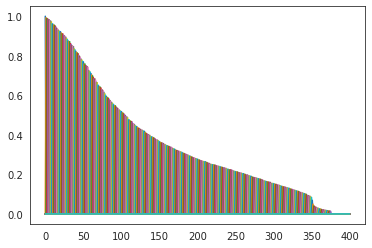

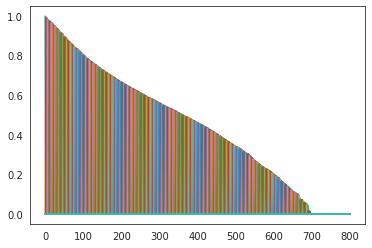

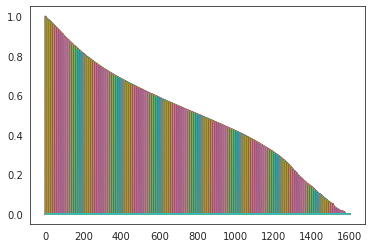

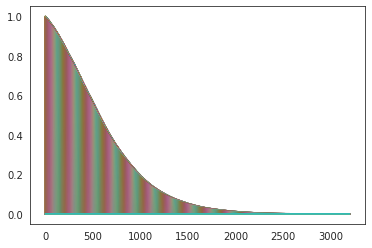

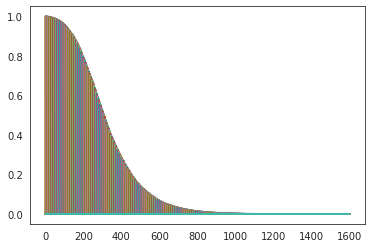

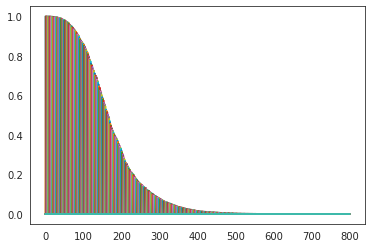

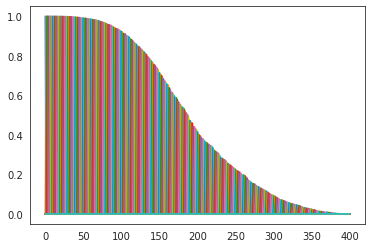

Task 2


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 574792.929590188


 20%|██        | 1/5 [01:35<06:23, 95.76s/it]

Test/validation loss: 0.08051813128050307
Train loss: 0.434212015542991


 40%|████      | 2/5 [03:02<04:30, 90.20s/it]

Test/validation loss: 0.07301828509185747
Train loss: 0.2023995462968902


 60%|██████    | 3/5 [04:28<02:56, 88.45s/it]

Test/validation loss: 0.07384224573684017
Train loss: 0.14982243095281536


 80%|████████  | 4/5 [05:54<01:27, 87.62s/it]

Test/validation loss: 0.06930853949304212
Train loss: 0.11899956761479727


100%|██████████| 5/5 [07:21<00:00, 88.24s/it]

Test/validation loss: 0.06775880441592451


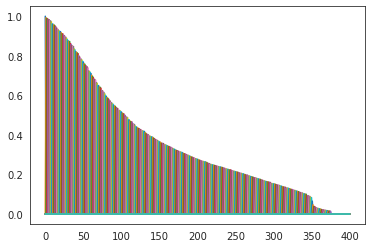

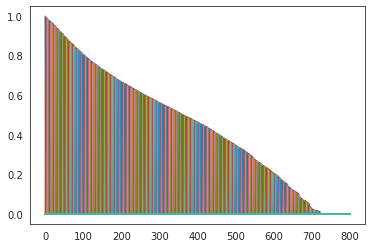

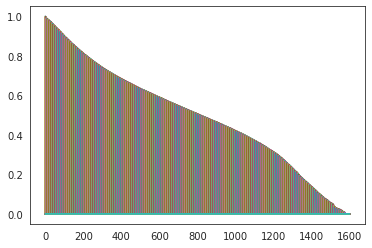

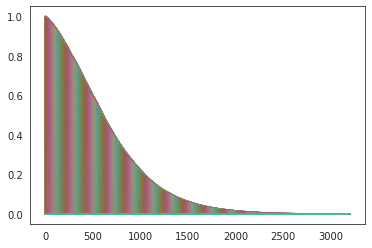

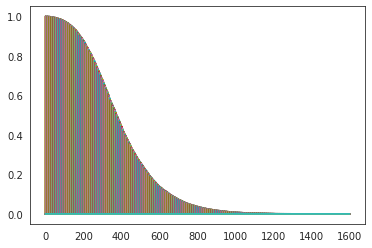

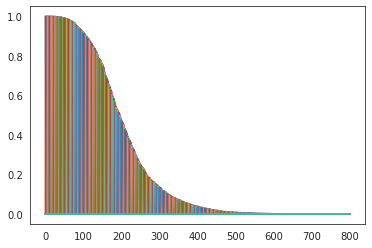

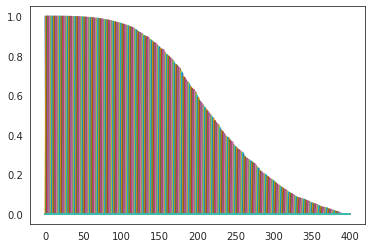

In [14]:
epochs = 5
weight_decay = 9 * 10e-8 # lambda
c_decay = 10e-1 # gamma
results = []
s_vals = []
for i in range(num_tasks):
    results.append([])
    s_vals.append([])
    print("Task", i+1)
    time.sleep(0.25)
    for epoch in tqdm(range(epochs)):
        train_loss = []
        test_loss = []
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            y = y[:,i,:,:]
            optimizer.zero_grad()
            out = model(x.float())
            if i != 0:
                loss = ce_loss(out.float(), y.float()) + weight_decay * l2_loss(model.weights) + c_decay * c_loss(model, A1, A2, A3, A4, A5, A6, A7)
            else:
                loss = ce_loss(out.float(), y.float()) + weight_decay * l2_loss(model.weights)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        print("Train loss:",statistics.mean(train_loss))

        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y = y[:,i,:,:]
            optimizer.zero_grad()
            out = model(x.float())
#             print(out.shape, y.shape)
            loss = ce_loss(out.float(), y.float())
            test_loss.append(loss.item())
        print("Test/validation loss:",statistics.mean(test_loss))
#     print("Generating results")
#     print("Overall", overall_iou())
#     for j in range(i+1):
#         print("Task", j, task_iou(j))
              
    time.sleep(0.25)
    
        
#     stop()

    col1 = []
    col2 = []
    col3 = []
    col4 = []
    col5 = []
    col6 = []
    col7 = []

    for _ in range(30):
        x,y = next(iter(trainloader))
        model(x.to(device))
        del x
        col1.append(model.x1.cpu())
        col2.append(model.x2.cpu())
        col3.append(model.x3.cpu())
        col4.append(model.x4.cpu())
        col5.append(model.x5.cpu())
        col6.append(model.x6.cpu())
        col7.append(model.x7.cpu())



    C1, _, _ = conceptor(torch.cat([torch.cat(list(c)) for c in col1], dim=0).cpu().detach().numpy())
    C2, _, _ = conceptor(torch.cat([torch.cat(list(c)) for c in col2], dim=0).cpu().detach().numpy())
    C3, _, _ = conceptor(torch.cat([torch.cat(list(c)) for c in col3], dim=0).cpu().detach().numpy())
    C4, _, _ = conceptor(torch.cat([torch.cat(list(c)) for c in col4], dim=0).cpu().detach().numpy())
    C5, _, _ = conceptor(torch.cat([torch.cat(list(c)) for c in col5], dim=0).cpu().detach().numpy())
    C6, _, _ = conceptor(torch.cat([torch.cat(list(c)) for c in col6], dim=0).cpu().detach().numpy())
    C7, _, _ = conceptor(torch.cat([torch.cat(list(c)) for c in col7], dim=0).cpu().detach().numpy())

    del col1, col2, col3, col4, col5, col6, col7

    if i == 0:
        A1 = torch.zeros(C1.shape)
        A2 = torch.zeros(C2.shape)
        A3 = torch.zeros(C3.shape)
        A4 = torch.zeros(C4.shape)
        A5 = torch.zeros(C5.shape)
        A6 = torch.zeros(C6.shape)
        A7 = torch.zeros(C7.shape)

        A1 = OR(C1, A1.numpy())
        A2 = OR(C2, A2.numpy())
        A3 = OR(C3, A3.numpy())
        A4 = OR(C4, A4.numpy())
        A5 = OR(C5, A5.numpy())
        A6 = OR(C6, A6.numpy())
        A7 = OR(C7, A7.numpy())

    else:
        A1 = OR(C1, A1.cpu().detach().numpy())
        A2 = OR(C2, A2.cpu().detach().numpy())
        A3 = OR(C3, A3.cpu().detach().numpy())
        A4 = OR(C4, A4.cpu().detach().numpy())
        A5 = OR(C5, A5.cpu().detach().numpy())
        A6 = OR(C6, A6.cpu().detach().numpy())
        A7 = OR(C7, A7.cpu().detach().numpy())

    _,s,_ = np.linalg.svd(A1)
    s_vals[i].append(s)
    _,s,_ = np.linalg.svd(A2)
    s_vals[i].append(s)
    _,s,_ = np.linalg.svd(A3)
    s_vals[i].append(s)
    _,s,_ = np.linalg.svd(A4)
    s_vals[i].append(s)
    _,s,_ = np.linalg.svd(A5)
    s_vals[i].append(s)
    _,s,_ = np.linalg.svd(A6)
    s_vals[i].append(s)
    _,s,_ = np.linalg.svd(A7)
    s_vals[i].append(s)
    del C1, C2, C3, C4, C5, C6, C7
    A1 = torch.from_numpy(A1).to(device).float()
    A2 = torch.from_numpy(A2).to(device).float()
    A3 = torch.from_numpy(A3).to(device).float()
    A4 = torch.from_numpy(A4).to(device).float()
    A5 = torch.from_numpy(A5).to(device).float()
    A6 = torch.from_numpy(A6).to(device).float()
    A7 = torch.from_numpy(A7).to(device).float()

    if i < num_tasks - 1:
        old1 = copy.deepcopy(model.w1.data) + copy.deepcopy(model.w1_old.data)
        old2 = copy.deepcopy(model.w2.data) + copy.deepcopy(model.w2_old.data)
        old3 = copy.deepcopy(model.w3.data) + copy.deepcopy(model.w3_old.data)
        old4 = copy.deepcopy(model.w4.data) + copy.deepcopy(model.w4_old.data)
        old5 = copy.deepcopy(model.w5.data) + copy.deepcopy(model.w5_old.data)
        old6 = copy.deepcopy(model.w6.data) + copy.deepcopy(model.w6_old.data)
        old7 = copy.deepcopy(model.w7.data) + copy.deepcopy(model.w7_old.data)
        old8 = copy.deepcopy(model.w8.data) + copy.deepcopy(model.w8_old.data)

        model.head.append(old8)

        model.w1_old = nn.Parameter(old1)
        model.w2_old = nn.Parameter(old2)
        model.w3_old = nn.Parameter(old3)
        model.w4_old = nn.Parameter(old4)
        model.w5_old = nn.Parameter(old5)
        model.w6_old = nn.Parameter(old6)
        model.w7_old = nn.Parameter(old7)
        model.w8_old = nn.Parameter(old8)

        model.initialise()   
    else:
        old8 = copy.deepcopy(model.w8.data) + copy.deepcopy(model.w8_old.data)
        model.head.append(old8)

2089
[0. 1. 2.]


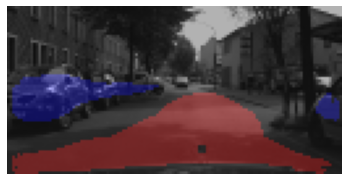

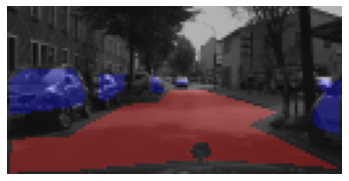

In [40]:
# code to generate images from model output and labels for two classes
model.w8_old = nn.Parameter(torch.zeros(model.w8_old.shape, device=device))
model.w8 = nn.Parameter(model.head[0])
r = random.randint(0,len(test))
print(r)
x,y = test.__getitem__(r)
output = model(torch.unsqueeze(x.to(device),0))
output = output.cpu().detach().numpy()
output[output > 0.5] = 1
output[output!=1] = 0
model.w8_old = nn.Parameter(torch.zeros(model.w8_old.shape, device=device))
model.w8 = nn.Parameter(model.head[1])
output1 = model(torch.unsqueeze(x.to(device),0))
output1 = output1.cpu().detach().numpy()
output1[output1 > 0.5] = 1
output1[output1!=1] = 0
outputs = np.zeros((64,128))
outputs[output==1] = 1
outputs[output1==1] = 2
print(np.unique(outputs))
x = x.numpy()
x = np.swapaxes(x, 0, 1)
x = np.swapaxes(x, 1, 2)
mask = label2rgb(outputs,x, bg_label=0, kind='overlay')
plt.imshow(mask)
plt.axis('off')
plt.show()
outputs = np.zeros((64,128))
outputs[y[0,:,:]==1] = 1
outputs[y[1,:,:]==1] = 2
# outputs[y[2,:,:]==1] = 3

mask = label2rgb(outputs,x, bg_label=0, kind='overlay')
plt.imshow(mask)
plt.axis('off')
plt.show()

2465
[0. 1.]


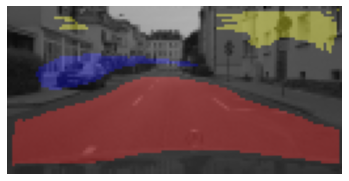

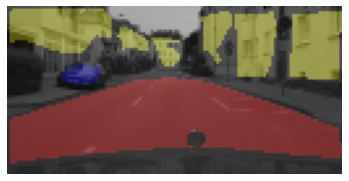

In [8]:
# code to generate images from model output and labels for three classes
model.w8_old = nn.Parameter(torch.zeros(model.w8_old.shape, device=device))
model.w8 = nn.Parameter(model.head[0])
r = random.randint(0,len(test))
print(r)
x,y = test.__getitem__(r)
output = model(torch.unsqueeze(x.to(device),0))
output = output.cpu().detach().numpy()
output[output > 0.5] = 1
output[output!=1] = 0
model.w8_old = nn.Parameter(torch.zeros(model.w8_old.shape, device=device))
model.w8 = nn.Parameter(model.head[1])
output1 = model(torch.unsqueeze(x.to(device),0))
output1 = output1.cpu().detach().numpy()
output1[output1 > 0.5] = 1
output1[output1!=1] = 0
model.w8_old = nn.Parameter(torch.zeros(model.w8_old.shape, device=device))
model.w8 = nn.Parameter(model.head[2])
output2 = model(torch.unsqueeze(x.to(device),0))
output2 = output2.cpu().detach().numpy()
output2[output2 > 0.5] = 1
output2[output2!=1] = 0
outputs = np.zeros((64,128))
outputs[output==1] = 1
outputs[output1==1] = 2
outputs[output2==1] = 3
print(np.unique(output2))
x = x.numpy()
x = np.swapaxes(x, 0, 1)
x = np.swapaxes(x, 1, 2)
mask = label2rgb(outputs,x, bg_label=0, kind='overlay')
plt.imshow(mask)
plt.axis('off')
plt.show()
outputs = np.zeros((64,128))
outputs[y[0,:,:]==1] = 1
outputs[y[1,:,:]==1] = 2
outputs[y[2,:,:]==1] = 3
mask = label2rgb(outputs,x, bg_label=0, kind='overlay')
plt.imshow(mask)
plt.axis('off')
plt.show()